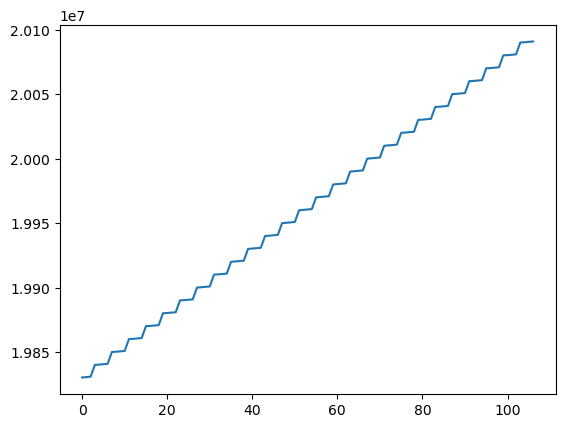

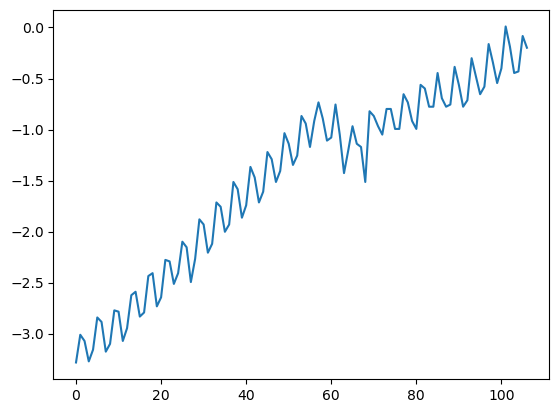

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

datos = pd.read_csv('coca_cola_earnings.csv', sep=";",decimal=",")

# x is the 1st column of the dataset representing the time
x = datos.iloc[:,0]
plt.plot(x)
plt.show()

# y is the 2nd column of the dataset representing the earnings
y = datos.iloc[:,1]
y = np.log(y)
plt.plot(y)
plt.show()

In [2]:
# !pip install pmdarima

In [3]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs

# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y,maxlag=10) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 4 # seasonal periodicity
d = ndiffs(y, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: -2.4470343860673696
p-value: 0.1288987849690012
Regular differences:  1
Seasonal differences: 1


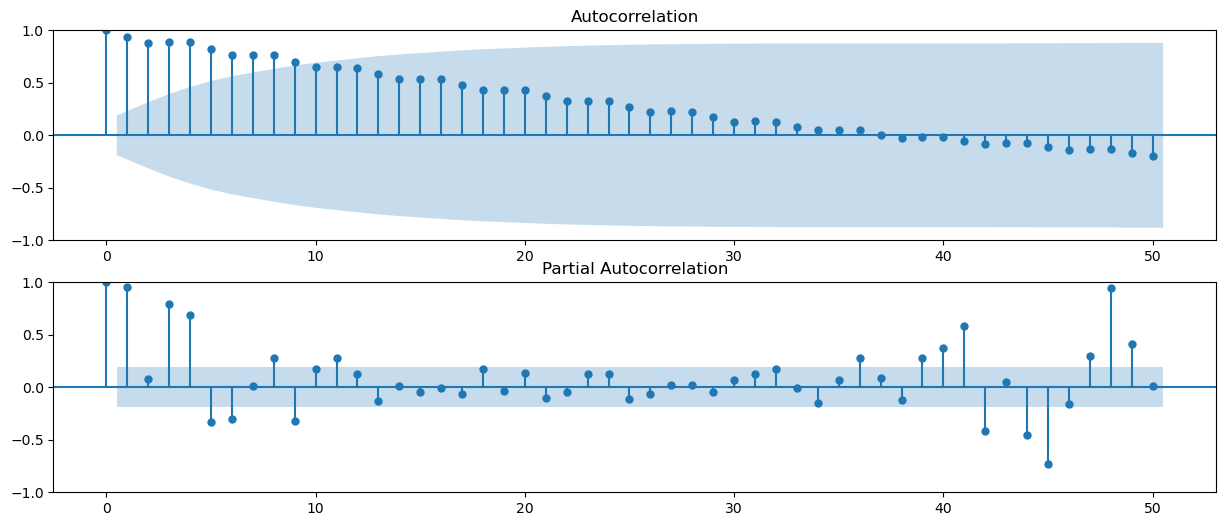

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 50 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y, lags = nlags, ax=ax[0])
plot_pacf(y, lags = nlags, method="ols", ax=ax[1])
plt.show()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.06437D-01    |proj g|=  3.06696D+00

At iterate    5    f= -9.49584D-01    |proj g|=  7.69871D-01

At iterate   10    f= -9.73129D-01    |proj g|=  3.65262D-01

At iterate   15    f= -9.74315D-01    |proj g|=  7.74117D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     23      1     0     0   4.635D-05  -9.743D-01
  F = -0.97431462340034147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

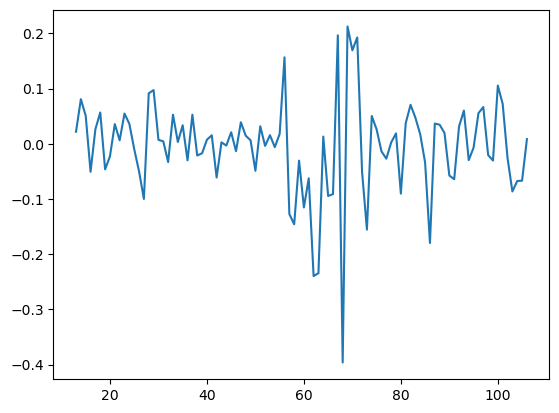

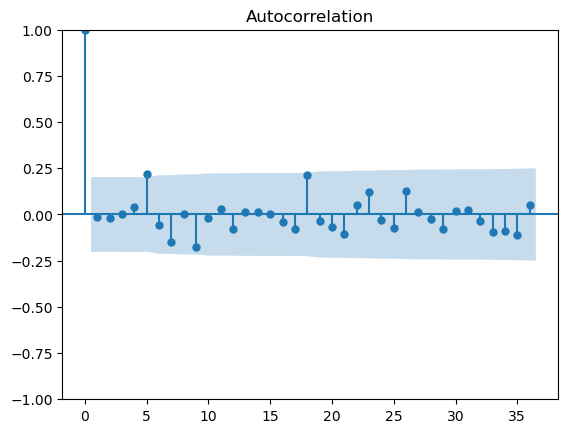

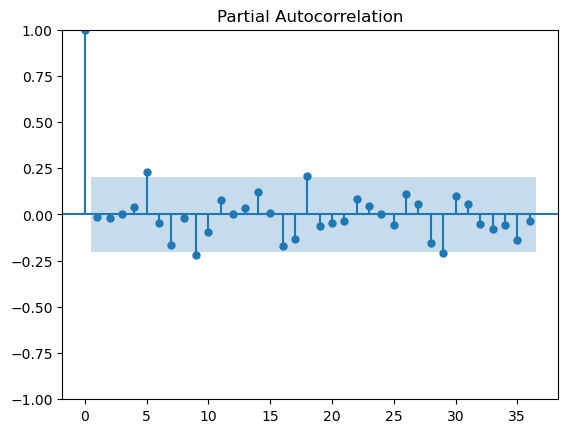

In [5]:
s = 4 # seasonal period

# fit = SARIMAX(endog = y, order = (0,1,1), seasonal_order = (2,1,1,s)).fit()
fit = SARIMAX(endog = y, order = (0,1,1), seasonal_order = (0,1,1,s)).fit()
print(fit.summary())
# RESIDUALS
residuos = fit.resid[13:]

nlags=36

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()

In [6]:
d = ndiffs(residuos, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(residuos, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

Regular differences:  1
Seasonal differences: 0


Ljung-Box for the residuals
      lb_stat  lb_pvalue
25  23.309168   0.559515
Shapiro test for residuals: Statistic value 0.9173921346664429 p-value 1.8080305380863138e-05


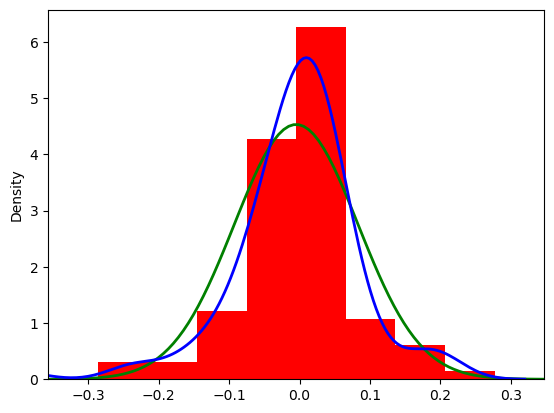

In [7]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[25])

print("Ljung-Box for the residuals")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapiro test for residuals: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)

plt.show()

# To have white noise, the p-value of the Ljung-Box test has to be greater than 0.05 (uncorrelated residuals)
# to have normality, the p-value of the Shapiro test has to be greater than 0.05

Ljung-Box for squared residuals
      lb_stat  lb_pvalue
20  55.741414   0.000032


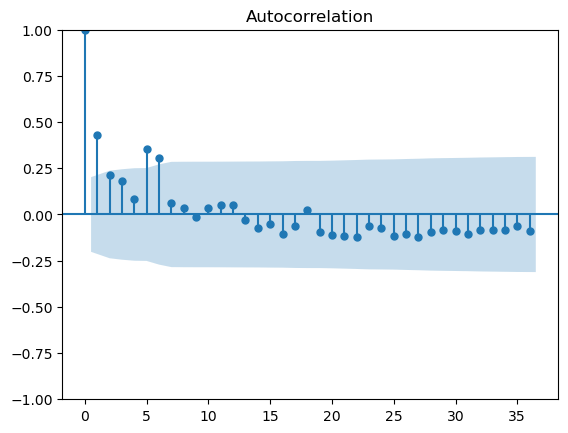

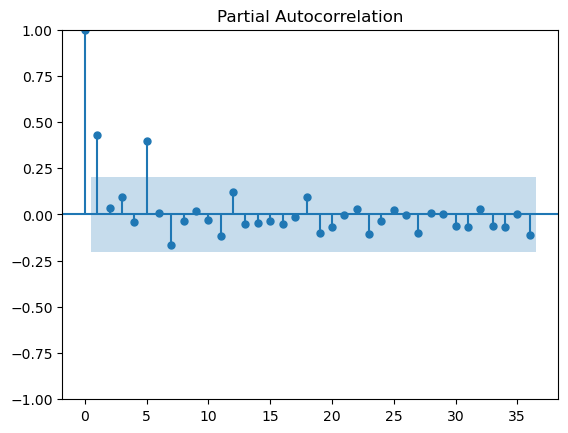

In [8]:
# Study the squared residuals for SWN

box_test2 = sm.stats.acorr_ljungbox(residuos**2, lags=[20])
print("Ljung-Box for squared residuals")
print(box_test2)

plot_acf(residuos**2,lags=nlags)
plt.show()
plot_pacf(residuos**2,lags=nlags,method="ols")
plt.show()

# if the p-value of the Ljung-Box test is greater than 0.05, the residuals are uncorrelated and we need a model for the variance.

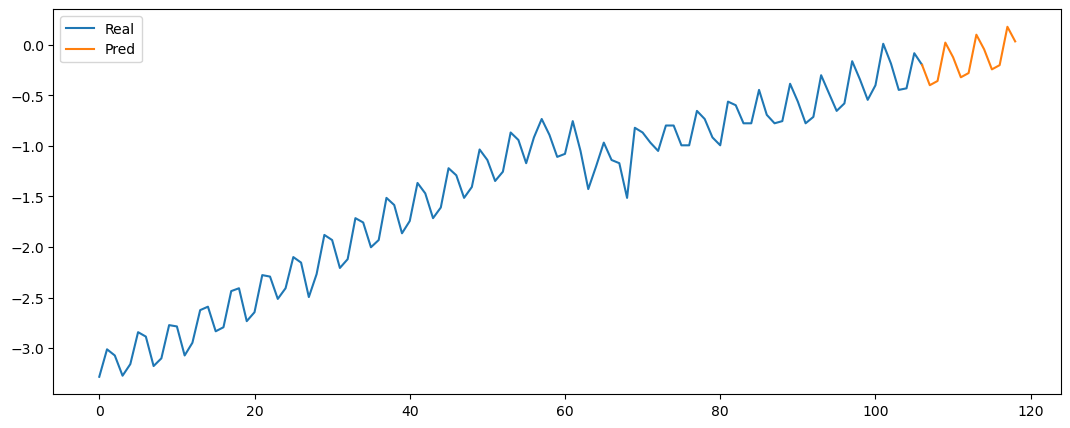

In [9]:
# Pintamos las siguientes 24 predicciones
y_pred = fit.forecast(steps = 12)

# Ponemos el último índice real
y_pred.loc[len(y)-1] = y[len(y)-1]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (13,5))
plt.plot(y, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()

In [10]:
# MORE FORECAST INFORMATION

forecast_result = fit.get_forecast(steps=12)
y_pred = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)  
stderr = forecast_result.se_mean 

print("point predictions")
print(y_pred)
print("confidence intervals around point predictions")
print(conf_int)
print("standard error of point predictions")
print(stderr)

point predictions
107   -0.399780
108   -0.358017
109    0.021439
110   -0.123072
111   -0.321514
112   -0.279752
113    0.099704
114   -0.044807
115   -0.243249
116   -0.201487
117    0.177969
118    0.033458
Name: predicted_mean, dtype: float64
confidence intervals around point predictions
     lower value  upper value
107    -0.566545    -0.233014
108    -0.551681    -0.164354
109    -0.195817     0.238695
110    -0.361599     0.115455
111    -0.592430    -0.050598
112    -0.574525     0.015020
113    -0.217134     0.416542
114    -0.382270     0.292656
115    -0.611005     0.124507
116    -0.592853     0.189880
117    -0.235662     0.591600
118    -0.401299     0.468215
standard error of point predictions
107    0.085086
108    0.098810
109    0.110847
110    0.121700
111    0.138225
112    0.150397
113    0.161655
114    0.172178
115    0.187634
116    0.199680
117    0.211040
118    0.221819
Name: var_pred_mean, dtype: float64


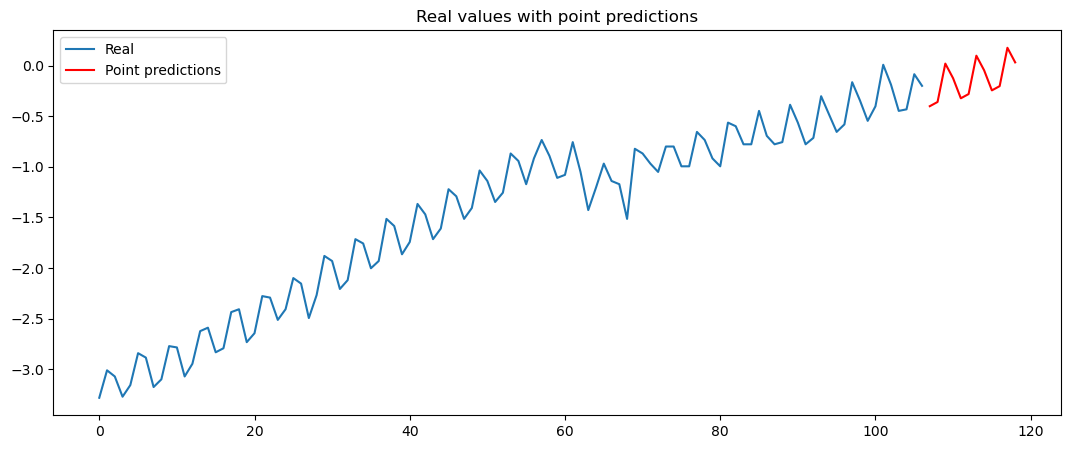

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

'''
Asumiendo que 'pred_means' contiene tus predicciones como una serie de pandas
y que 'y' es tu serie temporal original
'''

# Crear un nuevo índice para las predicciones que continúe desde el último índice de 'y'
nuevos_indices = range(y.index[-1] + 1, y.index[-1] + 1 + len(y_pred))

# Crear una nueva serie de pandas para las predicciones, usando los nuevos índices
y_predicciones = pd.Series(y_pred, index=nuevos_indices)

# Trazar
plt.figure(figsize=(13, 5))
plt.plot(y, label='Real')
plt.plot(y_predicciones, 'r', label='Point predictions')
plt.legend()
plt.title('Real values with point predictions')
plt.show()

In [12]:
# MORE FORECAST INFORMATION

media = np.mean(residuos)
desviacion_std = np.std(residuos)

# Standardized residuals
residuos_estand = (residuos - media) / desviacion_std

# Verification
#print("Standardized residuals:", residuos_estand)
print("Mean:", np.mean(residuos_estand))
print("Standard deviation:", np.std(residuos_estand))


quantile_2_5=np.quantile(residuos_estand, 0.025)
quantile_97_5=np.quantile(residuos_estand, 0.975)

print("We must compare the following numbers with +/- 1.96 from the standard normal")
print(quantile_2_5,quantile_97_5)

Mean: 1.8306869023074388e-17
Standard deviation: 0.9999999999999998
We must compare the following numbers with +/- 1.96 from the standard normal
-2.4027038421727407 2.1598986763408865
